In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# Dataset class definition
class AccidentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing and data augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CSV file path
csv_file = r"C:\Users\ime203\Desktop\Graduation\image_labels.csv"

# Load dataset
dataset = AccidentDataset(csv_file, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)



Epoch 1/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [21:32<00:00,  3.46s/it]


Epoch [1/5], Loss: 1.2469, Train Accuracy: 0.5009


Epoch 1/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:04<00:00,  2.60s/it]


Epoch [1/5], Validation Loss: 1.2408, Validation Accuracy: 0.4995


Epoch 2/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [19:47<00:00,  3.18s/it]


Epoch [2/5], Loss: 1.2420, Train Accuracy: 0.5026


Epoch 2/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:57<00:00,  2.53s/it]


Epoch [2/5], Validation Loss: 1.2417, Validation Accuracy: 0.4995


Epoch 3/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [19:42<00:00,  3.16s/it]


Epoch [3/5], Loss: 1.2414, Train Accuracy: 0.5026


Epoch 3/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:43<00:00,  2.38s/it]


Epoch [3/5], Validation Loss: 1.2405, Validation Accuracy: 0.4995


Epoch 4/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [19:21<00:00,  3.11s/it]


Epoch [4/5], Loss: 1.2409, Train Accuracy: 0.5026


Epoch 4/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:42<00:00,  2.36s/it]


Epoch [4/5], Validation Loss: 1.2400, Validation Accuracy: 0.4995


Epoch 5/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [19:38<00:00,  3.15s/it]


Epoch [5/5], Loss: 1.2407, Train Accuracy: 0.5026


Epoch 5/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [03:42<00:00,  2.36s/it]


Epoch [5/5], Validation Loss: 1.2417, Validation Accuracy: 0.4995


Final Validation: 100%|████████████████████████████████████████████████████████████████| 94/94 [03:43<00:00,  2.38s/it]
C:\Users\ime203\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Validation Accuracy: 0.4994981599197056
Final Precision: 0.24949841176317178
Final Recall: 0.4994981599197056
Final F1 Score: 0.3327758825346365


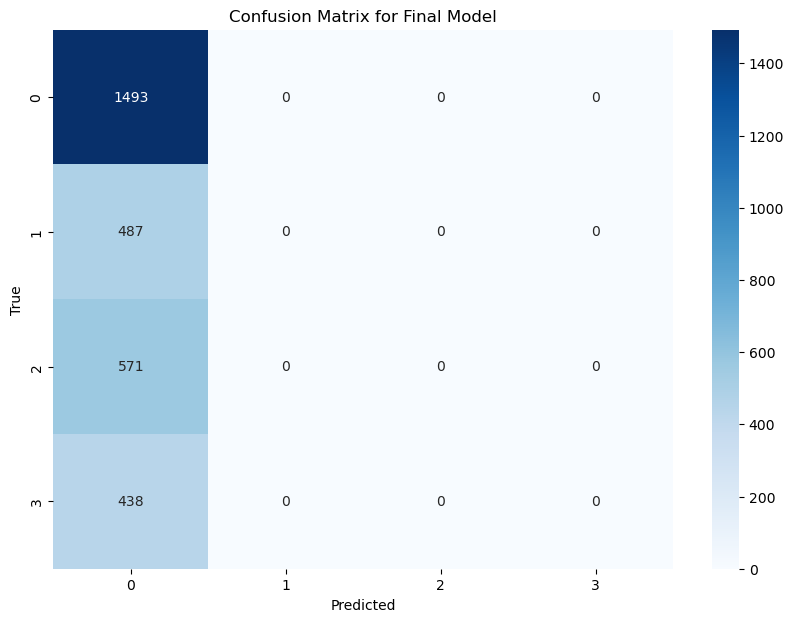

In [4]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm


# CNN+LSTM model definition using SqueezeNet
class CNNLSTMClassifierSqueezeNet(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, lstm_layers=2, lstm_dropout=0.5):
        super(CNNLSTMClassifierSqueezeNet, self).__init__()
        self.cnn = models.squeezenet1_0(pretrained=True)
        self.cnn.classifier[1] = nn.Conv2d(512, hidden_dim, kernel_size=(1, 1), stride=(1, 1))
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 5:
            batch_size, seq_length, c, h, w = x.size()
            cnn_out = []
            for t in range(seq_length):
                cnn_out.append(self.cnn(x[:, t, :, :, :]).view(batch_size, -1))

            cnn_out = torch.stack(cnn_out, dim=1)
            lstm_out, _ = self.lstm(cnn_out)
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        elif len(x.shape) == 4:
            cnn_out = self.cnn(x).view(x.size(0), -1)
            lstm_out, _ = self.lstm(cnn_out.unsqueeze(1))
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        else:
            raise ValueError("Unsupported input shape")

        return out

# Initialize the CNN+LSTM model using SqueezeNet
num_classes = 4
cnn_lstm_model = CNNLSTMClassifierSqueezeNet(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=0.001)

# Training the CNN+LSTM model
num_epochs = 5
for epoch in range(num_epochs):
    cnn_lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        outputs = cnn_lstm_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    cnn_lstm_model.eval()
    val_running_loss = 0.0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            outputs = cnn_lstm_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.numpy())
            val_labels.extend(labels.numpy())

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_loss = val_running_loss / len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Final evaluation
cnn_lstm_model.eval()
val_predictions = []
val_labels = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation"):
        outputs = cnn_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.numpy())
        val_labels.extend(labels.numpy())

# Evaluate the final model
val_accuracy = accuracy_score(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)
prec = precision_score(val_labels, val_predictions, average='weighted')
rec = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

print(f'Final Validation Accuracy: {val_accuracy}')
print(f'Final Precision: {prec}')
print(f'Final Recall: {rec}')
print(f'Final F1 Score: {f1}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Final Model')
plt.show()


